# Formula One Exploratory Analysis

I wanted to dive into Formula One data to find out what's in this particular dataset, and identify some questions I can follow-up on for more focused analysis. 

Starting out, I have these questions in mind - mainly motivated by curiosity:

 - In Formula One, does the winner of qualifying often go on to win the race?
 - What is the distribution of nationalities for Formula One drivers? What is the distribution of nationalities for Formula One constructors?
 - Who are the all-time top-ranking drivers? Who are the all-time top-ranking constructors?
 - What's the longest pit stop recorded in this dataset? What's the shortest pit stop recorded? Has the average pit stop duration decreased over time?

## Initial Setup and Cleaning of Data

In [693]:
import pandas as pd
from pandas import Series, DataFrame
from matplotlib import pyplot as plt
import os
import seaborn as sns

sns.set_theme(style='whitegrid')

In [645]:
# create full scope column reference since none exists
df_columns = None

for filename in os.listdir('Data'):
  if (filename != '.git'):
    df_columns_tmp = DataFrame(
      {
        'filename': filename,
        'columns': pd.read_csv('Data/'+ filename).columns
      }
    )
    if df_columns is not None:
      df_columns = df_columns.append(df_columns_tmp)
    elif df_columns is None:
      df_columns = df_columns_tmp

df_columns.to_csv('Metadata.csv')

# initialize dataframes
df_circuits = pd.read_csv('Data/circuits.csv')
df_qualifying = pd.read_csv('Data/qualifying.csv')
df_races = pd.read_csv('Data/races.csv')
df_results = pd.read_csv('Data/results.csv')
df_drivers = pd.read_csv('Data/drivers.csv')
df_constructors = pd.read_csv('Data/constructors.csv')
df_seasons = pd.read_csv('Data/Seasons.csv')
df_driverStandings = pd.read_csv('Data/DriverStandings.csv')
df_constructorStandings = pd.read_csv('Data/ConstructorStandings.csv')

In [658]:
# helper function for data quality check of dataframes
def get_unique_value_counts(dataframe):
  result = {'count_records':dataframe.shape[0]}
  for column in dataframe.columns:
    result[f'count_{column}'] = dataframe[column].nunique()

  return Series(result)

def display_results(dataframe,description,limit=10):
  '''Helper function for displaying formated results from Python'''
  display(Markdown(f'### {description}'))
  display(dataframe[:limit])

In [683]:
display_results(get_unique_value_counts(df_results),'Results.csv unique value counts.')
display_results(get_unique_value_counts(df_qualifying),'Qualifying.csv unique value counts.')
display_results(get_unique_value_counts(df_drivers),'Drivers.csv unique value counts.')


df_dups = df_results[df_results.duplicated(subset=['raceId','positionOrder'], keep=False)]

display_text = f'''
### Results.csv Summary Counts
 - \# of duplicate rows: {df_dups.shape[0]}\n
 - \# of total rows: {df_results.shape[0]}

There are duplicate rows - but since they are a relatively
small fraction of the overall results, we can drop without
significantly impacting the outcome

'''

display(Markdown(display_text))
df_results = df_results.drop_duplicates(subset=['raceId','positionOrder'], keep=False)

### Results.csv unique value counts.

count_records          23777
count_resultId         23777
count_raceId             976
count_driverId           842
count_constructorId      207
count_number             128
count_grid                35
count_position            33
count_positionText        39
count_positionOrder       39
dtype: int64

### Qualifying.csv unique value counts.

count_records          7516
count_qualifyId        7516
count_raceId            345
count_driverId          153
count_constructorId      41
count_number             49
count_position           28
count_q1               6736
count_q2               3481
count_q3               2121
dtype: int64

### Drivers.csv unique value counts.

count_records        842
count_driverId       842
count_driverRef      842
count_number          37
count_code            81
count_forename       466
count_surname        785
count_dob            823
count_nationality     41
count_url            841
dtype: int64


### Results.csv Summary Counts
 - \# of duplicate rows: 224

 - \# of total rows: 23777

There are duplicate rows - but since they are a relatively
small fraction of the overall results, we can drop without
significantly impacting the outcome



### Removal of irrelevant datapoints

In [686]:
# remove race results for the Indianapolis 500
df_results = df_results[~df_results.raceId.isin(df_races[df_races.name == 'Indianapolis 500'].raceId)]

# remove drivers that did not race the average number of races for a season
df_results = df_results[
  df_results.driverId.isin(
    df_results.driverId.value_counts()[
      df_results.driverId.value_counts() >= 15].index
      )
    ]

# remove drivers that are no longer in the race results
df_drivers = df_drivers[df_drivers.driverId.isin(df_results.driverId)]

# remove constructors that are no longer in the race results
df_constructors = df_constructors[df_constructors.constructorId.isin(df_results.constructorId)]


## High Level Analysis

Text(0, 0.5, '% Frequency')

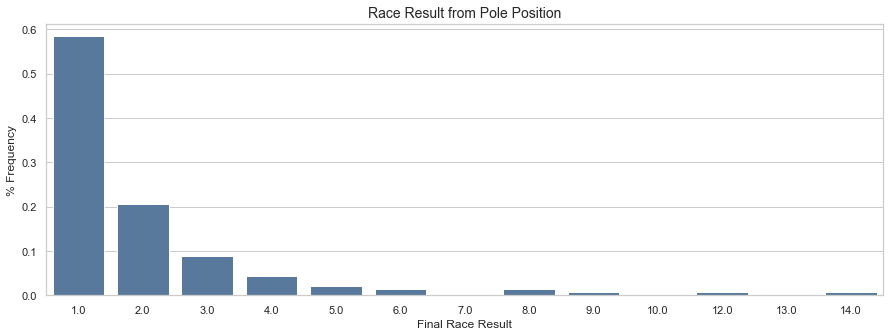

In [737]:
df_tmp = df_results.merge(df_qualifying,on=['raceId','driverId'],suffixes=['_result','_qual'])

# check for duplicates
df_tmp[df_tmp.duplicated(subset=['raceId','driverId'])]



# For what percentage of races did the winner of qualifying go on to win the race?
df_tmp2 = df_tmp[df_tmp.position_qual == 1].groupby('position_result',as_index=False).agg(count=pd.NamedAgg(column='resultId',aggfunc='nunique'))
df_tmp2['perc'] = df_tmp2['count']/df_tmp2.sum()['count']
# df_tmp2


plt.figure(figsize=(15,5))
graph = sns.barplot(
    data=df_tmp2,
    y ='perc',
    x='position_result',
    color='#4e79a7'
     ).set_title(
    'Race Result from Pole Position',
    size=14
    )

plt.xlabel('Final Race Result')
plt.ylabel('% Frequency')

Text(0, 0.5, 'Nationalities')

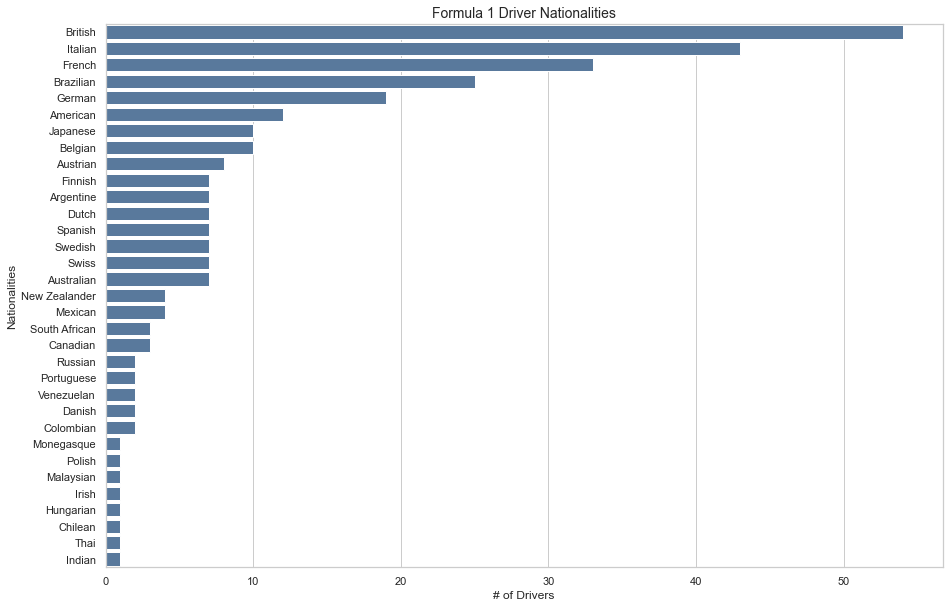

In [587]:
sns.set_theme(style='whitegrid')
plt.figure(figsize=(15,10))

# What is the distribution of nationalities for Formula 1 drivers?
df_tmp = df_drivers.groupby('nationality',as_index=False)\
  .agg(count_drivers = pd.NamedAgg(column='driverId',aggfunc='nunique'))\
  .sort_values('count_drivers',ascending=False)

plt.figure(figsize=(15,10))

graph = sns.barplot(
    data=df_tmp,
    y ='nationality',
    x='count_drivers',
    color='#4e79a7'
     ).set_title(
    'Formula 1 Driver Nationalities',
    size=14
    )

plt.xlabel('# of Drivers')
plt.ylabel('Nationalities')


Text(0, 0.5, 'Nationalities')

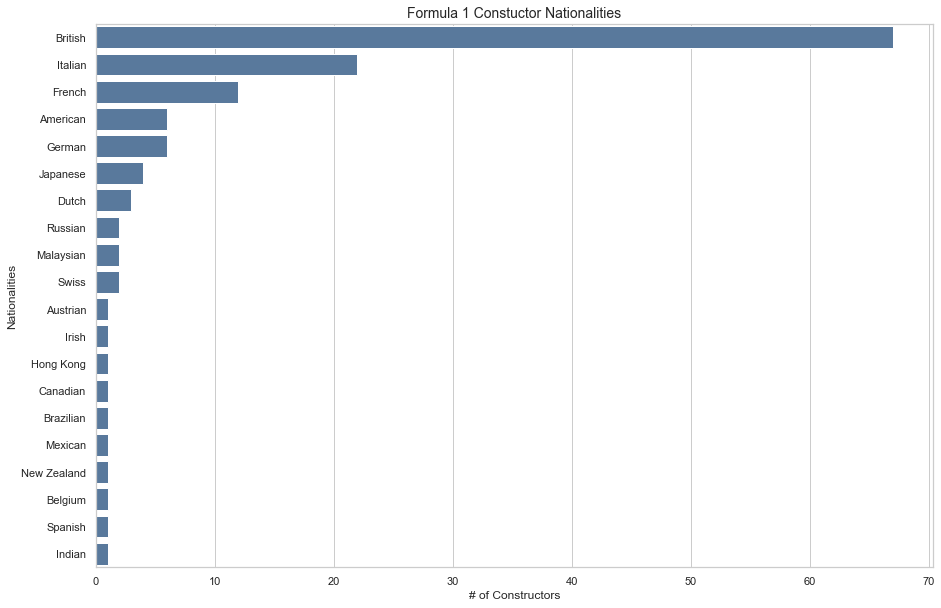

In [743]:
# What is the distribution of nationalities for Formula 1 drivers?
df_tmp = df_constructors.groupby('nationality',as_index=False)\
  .agg(count_constructors = pd.NamedAgg(column='constructorId',aggfunc='nunique'))\
  .sort_values('count_constructors',ascending=False)

plt.figure(figsize=(15,10))

graph = sns.barplot(
    data=df_tmp,
    y ='nationality',
    x='count_constructors',
    color='#4e79a7'
     ).set_title(
    'Formula 1 Constuctor Nationalities',
    size=14
    )
plt.xlabel('# of Constructors')
plt.ylabel('Nationalities')

## Formula One Drivers
### Summary Analysis

In [637]:
# get driver, season, total points
df_tmp = df_driverStandings \
  .merge(df_results, on=['raceId','driverId'],suffixes=['_standing','_result']) \
  .merge(df_races, on='raceId', suffixes=['_standing','_race'])\
  .merge(df_drivers, on='driverId',suffixes=['_standing','_driver'])\
  .merge(df_constructors, on='constructorId',suffixes=['_driver','_constructor'])

df_tmp2 = df_tmp.groupby(['year'], as_index=False).agg({'points_standing':'max'})

df_tmp3 = df_tmp.merge(df_tmp2, on=['year','points_standing'])\
  .drop_duplicates(subset=['year','points_standing','driverId'],keep='first')

# which drivers have the most titles?
df_tmp4 = df_tmp3.groupby(['surname','forename','nationality_driver','driverId'], as_index=False)\
  .agg(count_year = pd.NamedAgg(column='year',aggfunc='count'))\
  .sort_values(by='count_year', ascending=False)

display_results(df_tmp4,'Drivers with the most championships')

# which nations have the most driver's titles?
df_tmp5 = df_tmp4.groupby('nationality_driver',as_index=False)\
  .agg(count_titles = pd.NamedAgg(column='count_year',aggfunc='sum'))\
  .sort_values(by='count_titles',ascending=False)[:10]

display_results(df_tmp5,'Nations with the most driver\'s championships.')

# which nations have the most driver champions?
df_tmp5 = df_tmp4.groupby('nationality_driver',as_index=False)\
  .agg(count_drivers=pd.NamedAgg(column='driverId',aggfunc='nunique'))\
  .sort_values(by='count_drivers',ascending=False)[:10]

display_results(df_tmp5, 'Nations with the most driver\'s *champions*.')

# which drivers has won the most races in all Formula One history?
df_driver_wins = df_tmp[df_tmp.position_result==1]\
  .groupby(['driverId','surname','forename'],as_index=False)\
  .agg(count_wins=pd.NamedAgg(column='raceId',aggfunc='nunique'))\
  .sort_values(by='count_wins',ascending=False)

display(Markdown('### Formula 1 drivers with the most wins. '))
display(df_driver_wins[:10])

display_results(df_driver_wins, 'Formula 1 drivers with the most wins.')

# who are winning drivers that never won a driver's championship?
df_tmp5 = df_driver_wins[~df_driver_wins.driverId.isin(df_tmp3.driverId.values)]

display_results(df_tmp5, 'Top drivers that never won a driver''s championship.')


### Drivers with the most championships

,surname,forename,nationality_driver,driverId,count_year
27,Schumacher,Michael,German,30,7
6,Fangio,Juan,Argentine,579,5
31,Vettel,Sebastian,German,20,4
21,Prost,Alain,French,117,4
9,Hamilton,Lewis,British,1,4
3,Brabham,Jack,Australian,356,3
29,Stewart,Jackie,British,328,3
28,Senna,Ayrton,Brazilian,102,3
20,Piquet,Nelson,Brazilian,137,3
18,Lauda,Niki,Austrian,182,3


### Nations with the most driver's championships.

,nationality_driver,count_titles
5,British,17
9,German,12
4,Brazilian,8
1,Argentine,5
2,Australian,4
3,Austrian,4
7,Finnish,4
8,French,4
10,Italian,3
0,American,2


### Nations with the most driver's *champions*.

,nationality_driver,count_drivers
5,British,10
4,Brazilian,3
7,Finnish,3
9,German,3
0,American,2
2,Australian,2
3,Austrian,2
10,Italian,2
1,Argentine,1
6,Canadian,1


### Formula 1 drivers with the most wins. 

,driverId,surname,forename,count_wins
15,30,Schumacher,Michael,91
0,1,Hamilton,Lewis,62
29,117,Prost,Alain,51
11,20,Vettel,Sebastian,47
27,102,Senna,Ayrton,41
2,4,Alonso,Fernando,32
26,95,Mansell,Nigel,31
64,328,Stewart,Jackie,27
40,182,Lauda,Niki,25
73,373,Clark,Jim,25


### Formula 1 drivers with the most wins.

,driverId,surname,forename,count_wins
15,30,Schumacher,Michael,91
0,1,Hamilton,Lewis,62
29,117,Prost,Alain,51
11,20,Vettel,Sebastian,47
27,102,Senna,Ayrton,41
2,4,Alonso,Fernando,32
26,95,Mansell,Nigel,31
64,328,Stewart,Jackie,27
40,182,Lauda,Niki,25
73,373,Clark,Jim,25


### Top drivers that never won a drivers championship.

,driverId,surname,forename,count_wins
80,475,Moss,Stirling,15
7,14,Coulthard,David,13
42,199,Reutemann,Carlos,12
13,22,Barrichello,Rubens,11
6,13,Massa,Felipe,11
55,238,Peterson,Ronnie,10
25,77,Berger,Gerhard,10
9,17,Webber,Mark,9
54,235,Ickx,Jacky,8
34,163,Arnoux,Ren̩,7


## Formula One Constructors
### Summary Analysis

In [745]:
# get constructor, total season points

df_tmp = df_constructorStandings\
  .merge(df_races,on=['raceId'],suffixes=['_standing','_race'])\
  .merge(df_constructors, on=['constructorId'],suffixes=['_races','_constructor'])


# df_tmp.groupby(['year','name_constructor']).agg(max_points=pd.NamedAgg(column='points_standings_standing',aggfunc='max'))
df_tmp2 = df_tmp.groupby(['year'],as_index=False)\
  .agg(max_points=pd.NamedAgg(column='points',aggfunc='max'))

df_tmp3 = df_tmp.merge(
    df_tmp2, left_on=['year','points'],
    right_on=['year','max_points']
  ).drop_duplicates(subset=['year','constructorId'])

# which constructor has the most championships?
df_tmp4 = df_tmp3.groupby(['constructorId','name_constructor','nationality'],as_index=False)\
  .agg(count_years=pd.NamedAgg(column='year',aggfunc='nunique'))\
  .sort_values(by='count_years',ascending=False)

display_results(df_tmp4,'Constructors with the most championships.')

# which nation has the most constructors championships?
df_tmp4 = df_tmp3.groupby(['nationality'],as_index=False)\
  .agg(count_years=pd.NamedAgg(column='year',aggfunc='nunique'))\
  .sort_values(by='count_years',ascending=False)

display_results(df_tmp4,'Nations with the most constructor\'s championships.')


### Constructors with the most championships.

,constructorId,name_constructor,nationality,count_years
3,6,Ferrari,Italian,15
0,1,McLaren,British,9
1,3,Williams,British,9
11,131,Mercedes,German,4
8,32,Team Lotus,British,4
4,9,Red Bull,Austrian,4
2,4,Renault,French,2
12,170,Cooper-Climax,British,2
13,172,Lotus-Climax,British,2
15,191,Brabham-Repco,British,2


### Nations with the most constructor's championships.

,nationality,count_years
1,British,33
4,Italian,16
0,Austrian,4
3,German,4
2,French,3


## Next steps

These are some potential next steps for analysis:
 - Time series analysis of average pit stop time, and how it's changed over the history of Formula One results
 - Geographic visualization that may reveal patterns related to race circuits, driver nationality, etc.
 - More general understanding of how qualfying placement relates to the final race result; I imagine a scatter plot could be effective for this
 - Segmentation of current analysis to see if there are any surprising differences when changing one or two variables